In [1]:
import tables
import numpy as np
import pandas as pd

In [2]:
file = tables.open_file("/mnt/nas/data/1s数据/stk_strN_0_endN_999.h5",mode="r")

In [3]:
print(file)

/mnt/nas/data/1s数据/stk_strN_0_endN_999.h5 (File) ''
Last modif.: '2024-05-23T21:45:45+00:00'
Object Tree: 
/ (RootGroup) ''
/datatime (EArray(10337940, 2)zlib(4)) ''
/mid (EArray(10337940, 1000)zlib(4)) ''
/stock_list (EArray(1000, 1)zlib(4)) ''
/volume (EArray(10337940, 1000)zlib(4)) ''



In [4]:
datetime = file.root.datatime[:]

In [5]:
mid_price = file.root.mid[:]

In [6]:
codes = file.root.stock_list[:]

In [7]:
mid_price.shape

(10337940, 1000)

In [8]:
datetime

array([[20210104,    93000],
       [20210104,    93001],
       [20210104,    93002],
       ...,
       [20231229,   145657],
       [20231229,   145658],
       [20231229,   145659]], dtype=int32)

In [9]:
import nutils
import common as cm 
code_100 = cm.SELECTED_CODES

In [10]:
code_str = [str(code[0]).zfill(6) for code in codes]

col_100 = [True if code in code_100 else False for code in code_str]
col_100 = [code_str.index(code) for code in code_100]

In [11]:
mp_100 = mid_price[:,col_100]

In [12]:
import numpy as np
import numba as nb

@nb.jit(nopython=True, parallel=True)
def calculate_log_returns(weighted_prices, index_1s):
    n_timestamps = weighted_prices.shape[0]
    log_returns = np.zeros(n_timestamps)
    raw_returns = np.zeros(n_timestamps)
    
    for i in nb.prange(n_timestamps):
        current_price = weighted_prices[i]
        future_prices = []
        for k in range(1, 181):
            future_index = i + k
            if future_index < n_timestamps and index_1s[future_index, 0] == index_1s[i, 0]:
                future_prices.append(weighted_prices[future_index])
            else:
                future_prices.append(current_price)
        future_prices = np.array(future_prices)
        raw_returns[i] = future_prices[-1] / current_price - 1
        log_returns[i] = np.log(future_prices[-1] / current_price)*1e4
    
    return raw_returns,log_returns

In [13]:
mp_100 = pd.DataFrame(mp_100).ffill(axis=0).values
w_mp_100 = mp_100.astype(np.float64).mean(1)
rawret,logret = calculate_log_returns(w_mp_100,datetime)

In [14]:
from numba import prange
nb.jit(nopython=True, parallel=True)
def calculate_excess_returns(
    stock_log_returns, stock_index, index_log_returns, index_index
):
    n_stock_timestamps = stock_log_returns.shape[0]
    n_index_timestamps = index_log_returns.shape[0]

    # Create arrays to store results
    excess_returns = np.full(n_stock_timestamps, np.nan)

    # Initialize pointers
    index_pointer = 0

    # Iterate through stock timestamps
    for i in prange(n_stock_timestamps):
        stock_date, stock_time = stock_index[i]

        # Move index pointer to the latest log return before or at the stock time
        while index_pointer < n_index_timestamps and (
            index_index[index_pointer, 0] < stock_date
            or (
                index_index[index_pointer, 0] == stock_date
                and index_index[index_pointer, 1] <= stock_time
            )
        ):
            index_pointer += 1

        # Ensure we have a valid pointer to use
        if index_pointer > 0:
            beta = index_log_returns[index_pointer - 1]
            # excess_returns[i] = stock_log_returns[i] - beta
            excess_returns[i] = (
                np.log(np.exp(stock_log_returns[i] / 1e4) - np.exp(beta / 1e4) + 1)
            ) * 1e4

    return excess_returns

In [15]:
import SharedArray as sa 
from h5py import File 
from tqdm import tqdm 

for cur_code in tqdm(cm.SELECTED_CODES):
    raw_label = sa.attach(f"label_{cur_code}")
    # raw_timestamp = sa.attach(f"timestamp_{cur_code}")
    with File(f"/mnt/nas/data/股票数据hdf5/stkCode_{cur_code}.h5","r") as f:
        raw_timestamp = f["timestamp"][:]
    ret = calculate_excess_returns(raw_label,raw_timestamp,logret,datetime)
    np.save(f"/mnt/disk2/excess_return/{cur_code}.npy",ret.astype(np.float32),)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1064217/693082876.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  excess_returns[i] = (
100%|██████████| 100/100 [59:41<00:00, 35.81s/it] 


In [16]:
raw_timestamp[3]

array([20210104,    93008])

In [17]:
logret.shape

(10337940,)

In [18]:
code = "000537"
raw_label = sa.attach(f"label_{code}")

new_label = np.load(f"/mnt/disk2/excess_return/{code}.npy")

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: ylabel='Density'>

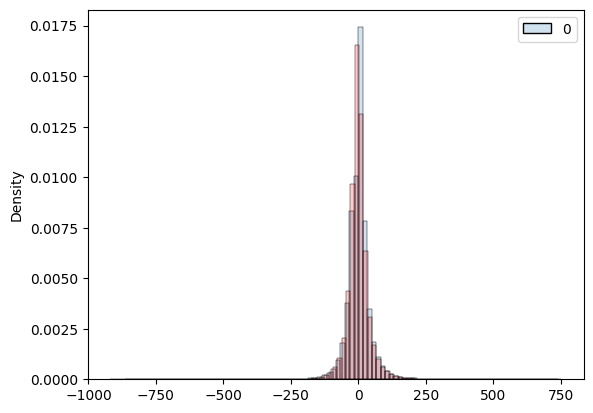

In [20]:
sns.histplot(raw_label,bins=100,stat="density",color="blue",alpha=0.2)
sns.histplot(new_label,bins=100,stat="density",color="red",alpha=0.2)

In [21]:

df_label = pd.DataFrame({"raw":raw_label.flatten(),"new":new_label.flatten()})

In [22]:
df_label.describe()

,raw,new
count,1.828412e+06,1.828412e+06
mean,3.012418e-01,2.226960e-01
std,4.207903e+01,4.047092e+01
min,-9.200058e+02,-8.638025e+02
25%,-1.848112e+01,-1.780306e+01
50%,0.000000e+00,-1.158781e+00
75%,1.733103e+01,1.573278e+01
max,7.514942e+02,7.401238e+02


In [23]:
df_label.corr()

,raw,new
raw,1.00000,0.95592
new,0.95592,1.00000
